In [18]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [19]:
para_distro = pd.read_csv(f"..\\..\\Cluster\\fittings\\second_dimension\\Traj_meta_1_0_10b.csv", names = ("Beta","Mu","Distance"))
for i in range(1,900):
    df = pd.read_csv(f"..\\..\\Cluster\\fittings\\second_dimension\\Traj_meta_1_{i}_10b.csv", names = ("Beta","Mu","Distance"))
    para_distro = pd.concat([para_distro,df])


In [20]:
para_distro["Beta"] = np.round(para_distro["Beta"],2)

C:\Users\ollie\AppData\Local\Temp\ipykernel_17748\1718393719.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  count_distro = pd.concat([count_distro,plot_bet_dis])


Mu        1.0       2.0       3.0       4.0       5.0       6.0       7.0   \
Beta                                                                         
1.0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1.1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1.2   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1.3   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1.4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...        ...       ...       ...       ...       ...       ...       ...   
9.5   0.336380  0.312614  0.150518  0.060329  0.024375  0.012188  0.010969   
9.6   0.323583  0.307739  0.151127  0.051798  0.032297  0.011578  0.011578   
9.7   0.321755  0.292505  0.146862  0.060938  0.027422  0.009750  0.008531   
9.8   0.315052  0.259598  0.108470  0.055454  0.019500  0.008531  0.007922   
9.9   0.312614  0.257770  0.106033  0.042657  0.023157  0.011578

C:\Users\ollie\AppData\Local\Temp\ipykernel_17748\1718393719.py:65: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


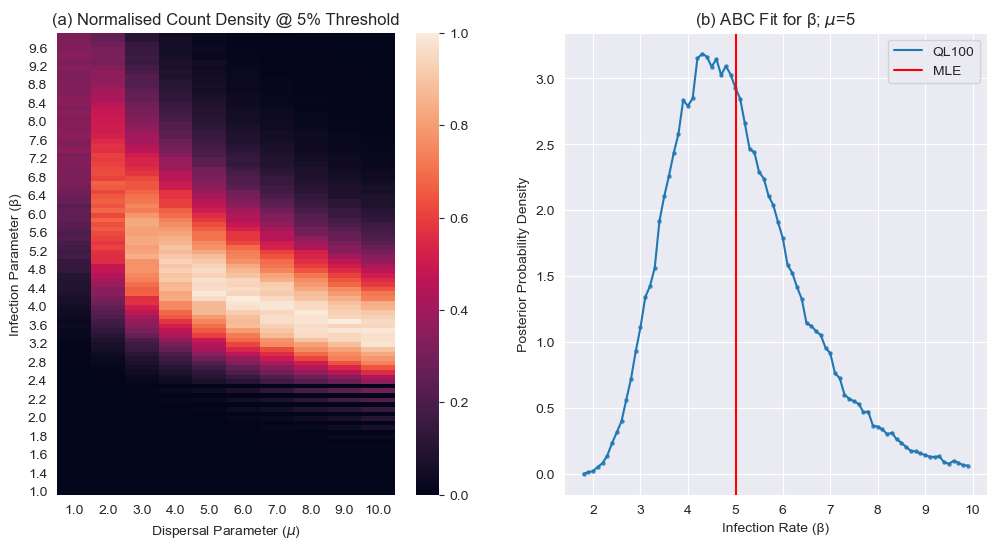

In [21]:
from src.PLS.ABC import ABC_rejection
from src.PLS.utils import threshold_scheduler
import scipy as sp
reference = [5]
count_distro = pd.DataFrame(columns= ("Beta","Counts", "Mu"))
df_ABC_all = para_distro[["Beta","Distance"]]
threshold_schedule = threshold_scheduler(df_ABC_all, reference)
for i in np.arange(1.0,11.0,1.0):
    mu_i =  para_distro[para_distro["Mu"] == i]
    df_ABC_i = mu_i[["Beta","Distance"]]
    graph_ABC = df_ABC_i.to_numpy()
    thresh = ABC_rejection(threshold_schedule[0], graph_ABC)
    if len(thresh) >0:
        ploted = pd.DataFrame(thresh, columns=["Beta", "Counts"])
        bet_dis = ploted.groupby("Beta").count()
        plot_bet_dis = bet_dis[bet_dis["Counts"] != 0]
        plot_bet_dis = bet_dis.reset_index()
        if np.round(min(plot_bet_dis["Beta"]),1) > 1:
            mins = np.arange(1,np.round(min(plot_bet_dis["Beta"]),1),0.1)
            df_mins =pd.DataFrame({"Beta": mins, "Counts": [0]*len(mins)})
            plot_bet_dis = pd.concat([plot_bet_dis,df_mins])
        if np.round(max(plot_bet_dis["Beta"]),1) < 9.9:
            maxs = np.arange(np.round(max(plot_bet_dis["Beta"]),1),9.9,0.1)
            df_maxs =pd.DataFrame({"Beta": maxs, "Counts": [0]*len(maxs)})
            plot_bet_dis = pd.concat([plot_bet_dis,df_maxs])
        plot_bet_dis = plot_bet_dis.sort_values("Beta",ascending=True)
        plot_bet_dis["Mu"] = i
        count_distro = pd.concat([count_distro,plot_bet_dis])
fig, ax0 = plt.subplots(ncols = 2, figsize = (12,6))
plot = pd.pivot_table(count_distro,values ='Counts', index=['Beta'], columns='Mu')
plot = plot.replace(np.nan, 0.0)
plot = plot/np.max(plot)
print(plot)
sns.heatmap(plot,ax=ax0[0])
ax0[0].invert_yaxis()
ax0[0].set_xlabel("Dispersal Parameter ($\mu$)")
ax0[0].set_ylabel("Infection Parameter (\u03B2)")
mu_5 =  para_distro[para_distro["Mu"] == 5]
df_ABC = mu_5[["Beta","Distance"]]
graph_ABC = df_ABC.to_numpy()
threshold_schedule = threshold_scheduler(df_ABC, reference)
for i in range(len(threshold_schedule)):
    thresh = ABC_rejection(threshold_schedule[i], graph_ABC)
    ploted = pd.DataFrame(thresh, columns=["Beta", "Counts"])
    bet_dis = ploted.groupby("Beta").count()
    plot_bet_dis = bet_dis[bet_dis["Counts"] != 0]
    max_scale = max(plot_bet_dis["Counts"])
    plot_bet_dis["Counts"] = plot_bet_dis["Counts"] / max_scale
    area = np.trapz(plot_bet_dis["Counts"],dx=0.01)
    plot_bet_dis["Counts"] = plot_bet_dis["Counts"] / area
    spline = sp.interpolate.CubicSpline(plot_bet_dis.index, plot_bet_dis["Counts"])
    ax0[1].scatter(bet_dis.index, plot_bet_dis["Counts"],
                            alpha=0.75,s=5)
    ax0[1].plot(plot_bet_dis.index, spline(plot_bet_dis.index), label="QL100")

    ax0[1].set_xlabel("Infection Rate (\u03B2)")
    ax0[1].set_ylabel("Posterior Probability Density")

    ax0[0].set_title("(a) Normalised Count Density @ 5% Threshold")
    ax0[1].set_title("(b) ABC Fit for \u03B2; $\mu$=5")

    mles = np.genfromtxt("../../Data/R0_5/Fitted/MLE_meta_b.csv")
    ax0[1].axvline(mles, color="red",label="MLE")
    ax0[1].legend()
fig.show()

In [22]:
from src.PLS.metaSIR import meta_no_ext_sir
from src.PLS.metaSIR import meta_sir
from src.PLS.metaSIR import meta_timed_sir
from decimal import Decimal, ROUND_UP
import time
from src.PLS.ABC import ABC_2d
from src.PLS.metaSIR import basic_square_map
from src.PLS.metaSIR import straight_line_distances
from src.PLS.metaSIR import basic_kernel

def sim_sir_fixed(b,m,model_rng):
    return meta_sir(X0,b,gamma,N,test_distances,basic_kernel,tmax,tstep,model_rng,dispersal = m) * factor
N = 4
distance_measure_array = ["sum_sq","sum_sqrt_sq","mixed","rinf","meta"]
dis = distance_measure_array[-1]
test_map = basic_square_map(N)
test_distances = straight_line_distances(test_map,N,scaling=10)
seed=1
R0 = 5
gamma = 1
X0 = [[999,1,0]]
div = sum(X0[0])
for i in range(N-1):
    X0.append([1000,0,0])
beta = R0/div
rng = np.random.default_rng(seed)
tstep = 0.01
tmax = 100
tmax = float(Decimal(tstep) * (Decimal(meta_timed_sir(X0,beta,gamma,N,test_distances,basic_kernel,tmax,tstep,rng) )/ Decimal(tstep)).quantize(1,rounding=ROUND_UP))
rng = np.random.default_rng(seed)


reality = meta_no_ext_sir(X0,beta,gamma,N,test_distances,basic_kernel,tmax,tstep,rng)
start_time = time.time()

X0 = [[9,1,0]]

for i in range(N-1):
    X0.append([10,0,0])

factor = 100

div = sum(X0[0])

In [ ]:
para_distro = pd.DataFrame(columns=("Beta","Mu","Distance"))
for i in range(1,11,1):
    for j in range(1,11,1):
        dispersal_para = [j]
        Rs =np.array([i])
        betas = Rs/div
        mus = dispersal_para

        applied_ABC = ABC_2d(sim_sir_fixed,betas,mus,reality,1000,f"{dis}",rng)
        applied_ABC[:,0] = applied_ABC[:,0]*div
        df = pd.DataFrame(applied_ABC,columns=("Beta","Mu","Distance"))
        para_distro = pd.concat([para_distro,df])

C:\Users\ollie\AppData\Local\Temp\ipykernel_17748\1869029251.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  para_distro = pd.concat([para_distro,df])


KeyboardInterrupt: 

In [ ]:
plot = pd.pivot_table(para_distro,values ='Distance', index=['Beta'], columns='Mu')

sns.heatmap(plot)